##### Interest level predictions
This notebook can be used to predict interest levels from videos (mp4 format) of online meetings. 

To start, you must have an MP4 file containing an online meeting. It is important that people do not join/leave during this video, as reshuffling of videofeed locations in the video can not be handled.

First, place the mp4 file into the `\data\video\` folder. Then in the code below, there are 2 string variables you must fill in before starting.
`filename` is simply the name of the videofile including the file format, so for example `filename =  'testvideo.mp4'`. `mapname` will be the name of the map generated to save temporary files, and also to store the output graphs of the application. You may name this whatever you want.

Additionally, some of the models below take hyperparameters. `detection_threshold` for the face detection model is a threshold for recognizing faces. The higher this number, the less likely it is to detect a face. If you put the value too low, it might also detect non-human objects as faces. This should typically be set in the range of `[0.7-0.9]`. Most models also have a `batch_size` variable, this one could be increased to speed up the models, but if the number is set too high it might crash. This is dependent both on your hardware, the video size, and the number of people in the video.

After running the code cells below, two interest prediction graphs will be saved to `mapje\mapname\`. One graph contains anonimized interest levels for each person in the video, and the other contains an aggregated graph.

If the graphs look too noise, try playing with the `window_size` variable in the final code cell. This feature handles the smoothing of the graph.

In [ ]:
import gc
import pandas as pd
from Models.tracking_persistence.face_tracking_persistence import face_persistence_model
from Models.face_detection.face_detection import face_detector
from Models.emotion_detection.aus_and_emo_detection import AuEmoDetectors
from Models.eye_tracking.mediapipe_wrapper import mediaPipeModel
from Preprocessing.personLabeler import personPersistenceManual
from Preprocessing.videoCropper import videoCropper
from Preprocessing.kalman import filterKalman
import os

filename = 'testvideo.mp4'
mapName = 'test'   

def check_create_dir(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created")
    else:
        print(f"Directory '{directory_path}' already exists")

## CALL THIS WHEN IMPORTING FROM PANDAS
def convert_whole_number_columns_to_int(df):
    for col in df.columns:
        # Check if the column has a numeric data type
        if pd.api.types.is_numeric_dtype(df[col]):
            # Check if all values in the column are whole numbers (i.e., the same when rounded)
            if df[col].eq(df[col].round()).all():
                # Convert the column to integers
                df[col] = df[col].astype(int)
    return df
   
check_create_dir(f"mapje/{mapName}")

facePredict = face_detector(filename=filename, detection_threshold=0.7, batch_size=12)
output = facePredict.runModelBatch()
output.to_csv(f'mapje/{mapName}/1_faceDetected.csv', index=False)
del facePredict
gc.collect()
print('collected bounding_boxes')

videoCrop = videoCropper(output, filename, displayVideo=False, saveCSV=False)
output, framerate, duration = videoCrop.runModel(csvName='test')
filename = 'cropped_'+filename
output.to_csv(f'mapje/{mapName}/2_cropped.csv', index=False)
del videoCrop
gc.collect()
print('cropped video')

p = personPersistenceManual(overlap_ratio=0.02)
output = p.assign_person_id(output)
output.to_csv(f'mapje/{mapName}/3_persistence.csv', index=False)
del p
gc.collect()
print('did person tracking')

face_tracker_model = face_persistence_model(TOLERANCE=0.6, filename=filename, model='cnn', modelSize='large', landmark_cuda=True)
output = face_tracker_model.runDetectionTrackOnlyBatch(output, False, batch_size=44)
output.to_csv(f'mapje/{mapName}/4_landmarks.csv', index=False)
del face_tracker_model
gc.collect()
print('completed landmarks')

# cols = ['x' + str(i) for i in range(68)] + ['y' + str(i) for i in range(68)]
# kalmanFilter = filterKalman(output, cols)
# output = kalmanFilter.runFilter()
# output.to_csv(f'mapje/{mapName}/5_kalman.csv', index=False)
# del kalmanFilter, cols
# gc.collect()
# print('completed kalman')

au_emo_detector = AuEmoDetectors(filename=filename, df=output, emoModel='resmasknet', device='cuda')
output = au_emo_detector.runModel(batch_size=128) 
output.to_csv(f'mapje/{mapName}/6_au_emo.csv', index=False)
del au_emo_detector
gc.collect()
print('completed au+emo')

media = mediaPipeModel(filename=filename, df=output, display=False)
output = media.runModel()
output.to_csv(f'mapje/{mapName}/7_mediapipe.csv', index=False)
del media
gc.collect()


In [2]:
import pandas as pd
import numpy as np
from Preprocessing.emotionMirroring import emotionMirroring
from Preprocessing.eyeFeatures import eyePreprocessor
ear = eyePreprocessor()
def calculate_differences(df, feature):
    df[feature + '_diff'] = df.groupby('Person')[feature].diff().fillna(0).round(3)
emoMirroring = emotionMirroring()

output = pd.read_csv(f'mapje/{mapName}/7_mediapipe.csv')
output = emoMirroring.runModel(output)
output.to_csv(f'mapje/{mapName}/8_emotionMirrored_no_kalmann.csv', index=False)

output = ear.get_EAR(output)
output = ear.pupilFeatures(output)

output.sort_values(by=['Frame', 'Person'], inplace=True)
output.reset_index(drop=True, inplace=True)


au_features = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9', 'AU10', 'AU11',
               'AU12', 'AU14', 'AU15', 'AU17', 'AU20', 'AU23', 'AU24', 'AU25', 'AU26',
               'AU28', 'AU43']

# List of emotion features
emotion_features = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']

# Calculate differences for AU features
for feature in au_features:
    calculate_differences(output, feature)

# Calculate differences for emotion features
for feature in emotion_features:
    calculate_differences(output, feature)

# Calculate differences for emotion mirroring
calculate_differences(output, 'emotion_mirroring')

output.to_csv(f'mapje/{mapName}/9_temporaled_no_kalmann.csv', index=False)

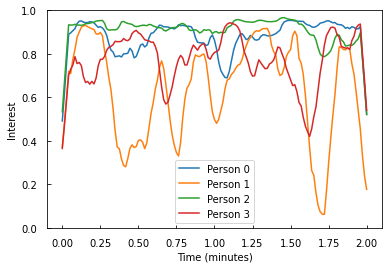

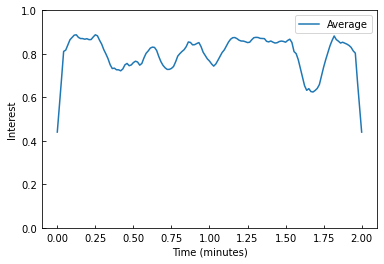

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import xgboost as xgb
from joblib import dump, load
from Preprocessing.preprocessPredictions import preprocessorPredictions

def smooth_data(data, window_size, method='average'):
    if method == 'average':
        window = np.ones(window_size) / window_size
        smoothed_data = np.convolve(data, window, mode='same')
    elif method == 'gaussian':
        window = np.hanning(window_size)
        window /= window.sum()
        smoothed_data = np.convolve(data, window, mode='same')
    else:
        raise ValueError(f"Unknown method: {method}")
    return smoothed_data

## Change this to make the graph more accurate or more readable.
window_size = 7
##################################################

# xgbModel = load('XGBModel.joblib')
svmModel = load('SVMModel.joblib')
prep = preprocessorPredictions()
filename = (f'mapje/{mapName}/9_temporaled_no_kalmann.csv')
features = prep.fullPreProcess(filename)
svmPredsproba = []
for person in features:
    svmpreds = svmModel.predict_proba(person)
    svmPredsproba.append(svmpreds)
    
max_length = max(len(lst) for lst in svmPredsproba)
duration = 120.5
totalFrames = duration * framerate
totalMinutes = round((duration / 60),1)
fixed_time = np.linspace(0, totalMinutes, max_length)

# Generate interest data (y-axis) between 0 and 1 for each person, but interpolate to the fixed number of points
interest_data = {}
for i, interest in enumerate(svmPredsproba):
    interest = interest[:, 1]
    original_time = np.linspace(0, int(totalMinutes), len(interest), endpoint=False)
    interpolated_interest = np.interp(fixed_time, original_time, interest)
    smoothed_interest = smooth_data(interpolated_interest, window_size, method='average')
    interest_data[f"Person {i}"] = smoothed_interest

# Create the plot
fig, ax = plt.subplots()

# Plot the data for each person
for label, interest in interest_data.items():
    ax.plot(fixed_time, interest, label=label)

# Set the x-axis and y-axis labels
ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Interest")

# Set the y-axis limits
ax.set_ylim(0, 1)

ax.tick_params(axis='both', direction='in', pad=10)
# Add a legend
ax.legend()
plt.savefig(f"mapje/{mapName}/timeline_graph.png", dpi=300, bbox_inches="tight")
# Show the plot
plt.show()


fig2, ax2 = plt.subplots()
# Compute the average interest at each time point and plot it
average_interest = np.mean(list(interest_data.values()), axis=0)
ax2.plot(fixed_time, average_interest, label='Average')
# Set the x-axis and y-axis labels
ax2.set_xlabel("Time (minutes)")
ax2.set_ylabel("Interest")
# Set the y-axis limits
ax2.set_ylim(0, 1)
ax2.tick_params(axis='both', direction='in', pad=5)
# Add a legend
ax2.legend()
plt.savefig(f"mapje/{mapName}/timeline_graph_aggregated.jpg", dpi=300, bbox_inches="tight")
# Show the plot
plt.show()


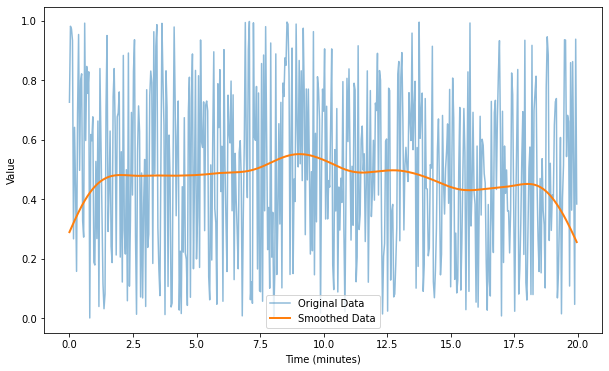

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
time = np.arange(0, 20, 1/25)
data = np.random.rand(len(time))

# Apply smoothing using a rolling window
def smooth_data(data, window_size, method='average'):
    if method == 'average':
        window = np.ones(window_size) / window_size
        smoothed_data = np.convolve(data, window, mode='same')
    elif method == 'gaussian':
        window = np.hanning(window_size)
        window /= window.sum()
        smoothed_data = np.convolve(data, window, mode='same')
    else:
        raise ValueError(f"Unknown method: {method}")
    return smoothed_data

window_size = 25 * 5  # Experiment with different window sizes
smoothed_data = smooth_data(data, window_size, method='gaussian')  # or method='gaussian'

# Plot the original and smoothed data
plt.figure(figsize=(10, 6))
plt.plot(time, data, label='Original Data', alpha=0.5)
plt.plot(time, smoothed_data, label='Smoothed Data', linewidth=2)
plt.xlabel('Time (minutes)')
plt.ylabel('Value')
plt.legend()
plt.show()